# Deepfake detection with more augmentation
As we experiment with different model and parameters on the section above, we find out that the model is overfitting on to the training dataset and the accuracy on the validation set improve slowly. We research on the internet and find out some experience and paper for the deep fake deteciton.

`Cross-Forgery Analysis of Vision Transformers and CNNs for Deepfake Image Detection https://doi.org/10.1145/3512732.3533582`

We first obtain some insight from the paper Cross-Forgery Analysis of Vision Transformers and CNNs for Deepfake Image Detection. The main contribution of this paper is to compare the performance of vision transformer and CNN in deep fake image detection. The author conduct experiments to compare the performance of the above on different deepfake generation methods including Face Transfer, Face Swap, FaceEditing. The author  apply transformations on image during training, including `Isotropic Resizeing, image compression, gaussian noise, horizontal flip, brightness or saturation distortion, grayscale conversion and shift, rotation or scaling`.  The result of this paper shows that the classification performance of CNN is better than Vision Transformer in deepfake detection, while Vision Transformers perform better at generalization,CNN perform better at accuracy.

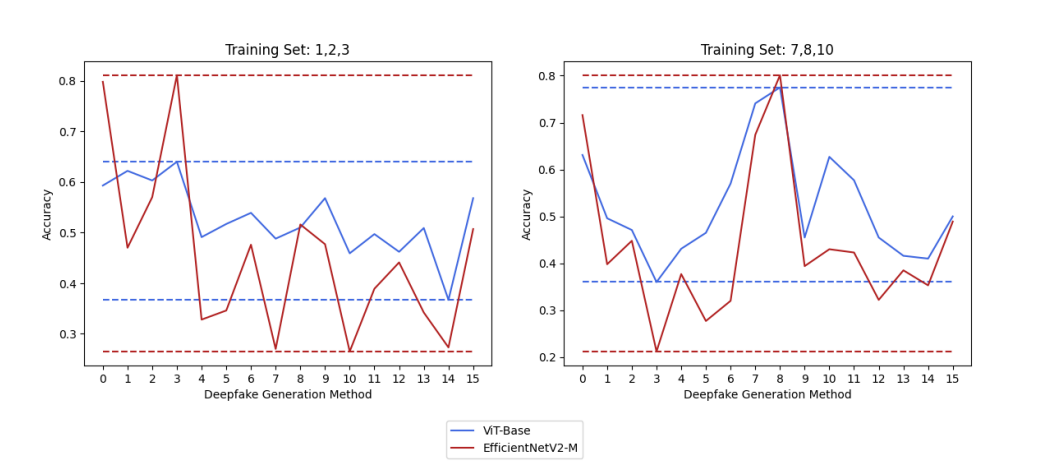



Another resource we obtained are:
The github repository:`https://github.com/selimsef/dfdc_deepfake_challenge` from selimsef.

Further reading, we found out that in this approach, a simple model using cnn and efficientnet as backbone is feasible for deep fake classification tasks, as stated in the repo, simple is the best. The image augmentation methods used are much more compare to our own mode. We found out that the data preprocessing is the key to improve the accuracy of the model.


The result of the resources above stating that our direction on applying transfer leanring to classify deep fake image is correct, and we need to apply more image preprocessing technique to obtain a better performance on the model.


# Image preprocessing
We try to implement and apply the image augmentation method as state from the above resources,
but keras and tensorflow's built in method for image augmentation is limited so we switch to pytorch
workflow and utilized the image augmentation libaray `albumentation` for image augmentation.

In [2]:
import torch
import random
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

import timm

from albumentations import Compose, RandomBrightnessContrast, \
    HorizontalFlip, FancyPCA, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, DualTransform

from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter


IMAGE_SIZE = 224
random.seed(42)

In [3]:
# set the device to cuda if available to speed up training
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name())
else:
    device = torch.device('cpu')

'NVIDIA GeForce RTX 4090'

# Pretrained model
EfficientNet shows the capability on deep fake image classification tasks,
so we are using it with pretrained weight on imagenet and fine-tune the model.

In [4]:
# Load efficientnetv2_m model with pre-trained weights
# num_classes=1 for binary classification
model = timm.create_model('tf_efficientnetv2_m', pretrained=True, num_classes=1)

# Freeze all layers except "blocks.6" and "blocks.5", and the last 10 layers
# to fine tune the model
for index, (name, param) in enumerate(model.named_parameters()):
    if "blocks.6" in name or "blocks.5" in name or index > len(list(model.parameters()))-10:
        param.requires_grad = True
    else:                    
        param.requires_grad = False

In [5]:
# Load data

# input data floder path
DATA_PATH = 'project_data'

dataset = []
labels = []

# iterate through all the file structures and load all the JPG or PNG files
for root, folders, files in os.walk(DATA_PATH):
    for file in files:
        if not file.endswith('.jpg') | file.endswith('.png'):
            continue
        
        # only load the address to the images but not the images thamselves to save time
        dataset.append(f'{root}/{file}')
        labels.append(0 if ('Fake' in root) | ('fake' in root) else 1)

In [6]:
# Train test split

# We use 90% of the data for training and 10% for validation here
train_dataset, validation_dataset, train_labels, validation_labels = train_test_split(dataset, labels, test_size=0.1, random_state=42)
del dataset

# Image preprocessing
According to the resource above and various deep fake detection implementation and online resources, we found out that the image preprocessing is the key to improve the generalization ability and accuracy of the model. It is even more important than the model architecture selection. Without using a large parameter model like vision transformer, we can still achieve a good accuracy with a simple model by using proper image preprocessing for face.
We try to see if we can re-create the good accuracy using the same set of image transformation.


In [7]:
# https://github.com/selimsef/dfdc_deepfake_challenge/blob/master/training/transforms/albu.py
class IsotropicResize(DualTransform):
    def __init__(self, max_side, interpolation_down, interpolation_up):
        super(IsotropicResize, self).__init__(False, 1)
        self.max_side = max_side
        self.interpolation_down = interpolation_down
        self.interpolation_up = interpolation_up

    # resize the images and make sure the height and width are the same
    def apply(self, img, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC, **params):

        h, w = img.shape[:2]

        if max(w, h) == self.max_side:
            return img
        if w > h:
            scale = self.max_side / w
            h = h * scale
            w = self.max_side
        else:
            scale = self.max_side / h
            w = w * scale
            h = self.max_side
        interpolation = interpolation_up if scale > 1 else interpolation_down

        img = img.astype('uint8')
        resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
        return resized

    def apply_to_mask(self, img, **params):
        return self.apply(img, interpolation_down=cv2.INTER_NEAREST, interpolation_up=cv2.INTER_NEAREST, **params)

    def get_transform_init_args_names(self):
        return ("max_side", "interpolation_down", "interpolation_up")

# Data loader
The dataloader to apply the image augmentation,
`Isotropic Resizeing, image compression, gaussian noise, horizontal flip, brightness or saturation distortion, grayscale conversion and shift, rotation or scaling` is applied.

In [8]:
# Define dataloader
class DeepFakesDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, image_size, mode='train'):
        self.image_paths = image_paths
        self.labels = torch.from_numpy(labels)
        self.image_size = image_size
        self.mode = mode
        self.n_samples = len(image_paths)
    
    # for the training set, we create more variation of the images so that our model can deal with different situations.
    def create_train_transforms(self, size):
        return Compose([
            ImageCompression(quality_lower=60, quality_upper=100, p=0.2),
            GaussNoise(p=0.3),
            HorizontalFlip(),
            OneOf([
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
            ], p=1),
            PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
            OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.4),
            ToGray(p=0.2),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=5, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        ]
        )
        
    # only resize and pad the borders if needed for the validation set.
    def create_val_transform(self, size):
        return Compose([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        ])

    # only load the images when needed and transform based on the mode (training or validation/testing)
    def __getitem__(self, index):
        image = np.asarray(cv2.imread(self.image_paths[index]))
        
        if self.mode == 'train':
            transform = self.create_train_transforms(self.image_size)
        else:
            transform = self.create_val_transform(self.image_size)
        
        image = transform(image=image)['image']
        
        return torch.tensor(image).float(), self.labels[index]

    def __len__(self):
        return self.n_samples

In [9]:
# Create the data loaders
BATCH_SIZE = 64

train_dataset = DeepFakesDataset(train_dataset, np.asarray(train_labels), IMAGE_SIZE)
dl = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
del train_dataset

validation_dataset = DeepFakesDataset(validation_dataset, np.asarray(validation_labels), IMAGE_SIZE, mode='validation')
val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
del validation_dataset

In [11]:
# The evaluate function to calculate the correct predictions, positive class and negative class
def evaluate(preds, labels):
    rounded_preds = preds.round()

    correct = sum(pred == label for pred, label in zip(rounded_preds, labels)).item()
    positive_class = int(sum(rounded_preds).item())
    negative_class = (len(rounded_preds) - positive_class)
    
    return correct, positive_class, negative_class

# Model Training
We train the model for the classification tasks.
Compared to tensorflow keras's`model.fit()`, more boilerplate code is written in pytorch, but it also provide more flexibility to control the train and test cycle. 

In [12]:
# Training

# hyperparameters
PATIENCE = 3
MAX_EPOCHS = 30
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0000001
STEP_SIZE = 15
GAMMA = 0.1

# paths for saving the model and logger
MODEL_PATH = 'Dec_10_models' # Name the folder for the models
LOGGER_PATH = 'runs/train' # Name the folder for the logger

tb_logger = SummaryWriter(log_dir=LOGGER_PATH, comment='')
experiment_path = tb_logger.get_logdir()

# Calculating class weights for the loss function
class_weights = sum(labels) / (len(labels) - sum(labels))
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights]))

# Defining the optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Model: Transfer to GPU for faster training or CPU, defined above
model = model.to(device)

# Early stopping counter
early_stop_count = 0
best_loss = float('inf')

# Training loop
for epoch in range(MAX_EPOCHS):
    
    # If the validation loss has not improved for a number of epochs stop training
    if early_stop_count == PATIENCE:
        break

    # Train loop: variables to hole the loss and accuracy for each epoch
    total_train_loss = 0
    train_correct = 0
    train_positive = 0
    train_negative = 0
    train_counter = 0

    # Train loop: loop over the training dataloader batche
    model.train()

    pbar = tqdm(dl, total=len(dl))
    for images, labels in pbar:
        # unsqueeze to match the dimension
        labels = labels.unsqueeze(1)
        # transpose the images to match the input dimension of the model and move them to the GPU if available
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.to(device)
        # Forward pass
        y_pred = model(images)
        y_pred = y_pred.cpu()
        
        # calculate the loss by loss func
        loss = loss_fn(y_pred, labels.float())
        
        # Evaluate the predictions on train data
        correct, positive_class, negative_class = evaluate(torch.sigmoid(y_pred.detach()), labels)
        train_correct += correct
        train_positive += positive_class
        train_negative += negative_class
        train_counter += 1
        
        # Backward pass
        optimizer.zero_grad() # remember to zero_grad
        loss.backward()
        optimizer.step()
        
        # Accumulate the total loss as defined per epoch
        total_train_loss += round(loss.item(), 2)
        
        # Show the loss and accuracy for tracking
        pbar.set_description(f'Training epoch: {epoch}/{MAX_EPOCHS}, loss: {total_train_loss/train_counter:.4f}, acc: {train_correct/(train_counter*BATCH_SIZE):.4f}, 0s/1s: {train_negative}/{train_positive}')


    # Compute the average loss and accuracy over the epoch
    train_correct /= dl.dataset.n_samples
    total_train_loss /= train_counter
    
    # Validating loop: variables to hole the loss and accuracy for each epoch
    total_val_loss = 0
    val_correct = 0
    val_positive = 0
    val_negative = 0
    val_counter = 0

    # Validating loop: loop validation dataloader batches
    model.eval()

    pbar = tqdm(val_dl, total=len(val_dl))
    for val_images, val_labels in pbar:
        
        # same as above to match dimension and move to GPU
        val_labels = val_labels.unsqueeze(1)
        val_images = np.transpose(val_images, (0, 3, 1, 2))
        val_images = val_images.to(device)
        
        # Forward pass
        with torch.no_grad():
            val_pred = model(val_images)
            val_pred = val_pred.cpu()
            # validation loss
            val_loss = loss_fn(val_pred, val_labels.float())
            # Evaluate the predictions on test data(validation data)
            corrects, positive_class, negative_class = evaluate(torch.sigmoid(val_pred), val_labels)

        val_correct += corrects
        val_positive += positive_class
        val_negative += negative_class
        val_counter += 1
        
        # NO backprop for validation
        
        # same as above,gather the total loss per epoch
        total_val_loss += round(val_loss.item(), 2)

        # Show the loss and accuracy for tracking
        pbar.set_description(f'Validate epoch: {epoch}/{MAX_EPOCHS}, loss: {total_val_loss/val_counter:.4f}, acc: {val_correct/(val_counter*BATCH_SIZE):.4f}, 0s/1s: {val_negative}/{val_positive}')
    
    # Update the learning rate by the LR scheduler
    scheduler.step()
    
    # Compute the average validation loss and accuracy over the epoch
    val_correct /= val_dl.dataset.n_samples
    total_val_loss /= val_counter
    
    # If validation loss is not improving,increase the early stop counter.
    if best_loss <= total_val_loss:
        tqdm.write('Validation loss did not improved')
        early_stop_count += 1
    else:
        best_loss = total_val_loss
        early_stop_count = 0
    
    # tensorboard logging
    tb_logger.add_scalar('Training/Accuracy', train_correct, epoch)
    tb_logger.add_scalar('Training/Loss', total_train_loss, epoch)
    tb_logger.add_scalar('Training/Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
    tb_logger.add_scalar('Validation/Loss', total_val_loss, epoch)
    tb_logger.add_scalar('Validation/Accuracy', val_correct, epoch)
    
    # error handling if path not exists
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    
    # save the model of this epoch
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'model_{epoch}'))

C:\Users\Doge\AppData\Local\Temp\ipykernel_25856\2183828665.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(preds[i])


Loss: 4.31, Accuracy: 0.546875, Train 0s/1s: 27/37

Epoch: 0/20, Validation Loss:0.5542528735632185, Validation Accuracy: 0.7029379760609358, Validation 0s/1s: 2135/3379
Loss: 0.6, Accuracy: 0.671875, Train 0s/1s: 36/28

Epoch: 1/20, Validation Loss:0.4889655172413793, Validation Accuracy: 0.749727965179543, Validation 0s/1s: 2285/3229
Loss: 0.57, Accuracy: 0.71875, Train 0s/1s: 28/36

Epoch: 2/20, Validation Loss:0.44206896551724145, Validation Accuracy: 0.7852738483859267, Validation 0s/1s: 2899/2615
Loss: 0.49, Accuracy: 0.71875, Train 0s/1s: 37/27

Epoch: 3/20, Validation Loss:0.41402298850574715, Validation Accuracy: 0.8014145810663765, Validation 0s/1s: 2976/2538
Loss: 0.41, Accuracy: 0.765625, Train 0s/1s: 35/29

Epoch: 4/20, Validation Loss:0.3588505747126436, Validation Accuracy: 0.8306129851287631, Validation 0s/1s: 2817/2697
Loss: 0.34, Accuracy: 0.828125, Train 0s/1s: 30/34

Epoch: 5/20, Validation Loss:0.35459770114942535, Validation Accuracy: 0.8387740297424737, Validatio

# Model Testing
We test the model for the classification tasks.
The testing procedure is similar to training. We load the data, and predict it with the trained model.

In [ ]:
# Load data
test_folder_path = 'project_data' # input test data floder

test_dataset = []
test_labels = []

for root, folders, files in os.walk(test_folder_path):
    for file in files:
        if not file.endswith('.jpg') | file.endswith('.png'):
            continue
        
        dataset.append(f'{root}/{file}')
        labels.append(0 if ('Fake' in root) | ('fake' in root) else 1)

In [ ]:
# Create the data loaders
BATCH_SIZE = 64

test_dataset = DeepFakesDataset(test_dataset, np.asarray(test_labels), IMAGE_SIZE, mode='validation')
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Testing

# select a model saved in the training
MODEL_PATH = 'model_33_10'

model = timm.create_model('tf_efficientnetv2_m', pretrained=True, num_classes=1)

# load the trained model
if torch.cuda.is_available():
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    model.load_state_dict(torch.load(MODEL_PATH), map_location=torch.device('cpu'))

model = model.to(device)
faces_preds = torch.Tensor()
all_labels = torch.Tensor()

# Testing loop: loop testing dataloader batches
model.eval()
for images, labels in tqdm(test_dl, desc='Testing'):
    # same as above to match dimension and move to GPU
    images = np.transpose(images, (0, 3, 1, 2))
    images = images.to(device)

    # Forward pass
    with torch.no_grad():
        # predict this batch of images
        y_pred = model(images)
    
    y_pred = y_pred.cpu()

    # store the predictions and the labels
    faces_preds = torch.cat((faces_preds, torch.sigmoid(y_pred)))
    all_labels = torch.cat((all_labels, labels))

# calculate the accuracy, positive cases and negative cases
corrects, positive, negative = evaluate(faces_preds, all_labels)
accuracy = corrects / len(all_labels)
accuracy